<h1 style="text-align:center">Battle of the Neighbourhoods</h1>
<img src='https://www.seetorontonow.com/wp-content/uploads/2020/06/Toronto-Skyline-view-from-lake.jpg'>

In this project I will be helping an Investor decide which part of Toronto to set up a Coffee shop. Various factors can affect the success of a startup shop. These Factors will be weighted and used to help our Investor decide which Part of Toronto to Invest in. The factors to be considered are:
<li>Viability: This refers to how feasible opening a coffee shop in any of the neighborhoods is. This viability index will be created based on the existing coffee shops in that region. This is based on the assumption that if there is a reasonable amount of coffee shops in a region it implies that the business is relatively profitable.
<li>Environmental Factors: Coffee shops do not stand in isolation. The presence of various establishments such as banks, sports centers, parks etc. within a region help to drive more traffic to such neighborhoods, which can improve the conditions for the proposed coffee shop.
<li>Population Density: People are constantly looking for a ‘third place’ to spend to spend time that’s neither work or home, so the more the people in a given location the more likely it is for the coffee shop to attract traffic.</li>

<br>In this project I will also try to analyze the various parts of Toronto city to see similarities between neighborhoods and discuss the upsides to moving into any of the similar Neighborhoods.


<h3>Section 1</h3>
Obtaining and cleaning the data

In [651]:
#Importing the Basic Python Packages Required for this project
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests 
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

A list of the Bouroughs and Neighbourhoods is obtained from a Wikipedia Page. This Data is Processed using BeautifulSoup and then processed into a dataframe

In [2]:
# import the libraries required to scrape the Web
from urllib import request
from bs4 import BeautifulSoup 

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
page = request.urlopen(url)
page

In [5]:
soup = BeautifulSoup(page, 'lxml')

In [6]:
Toronto_Data = soup.find('table', class_='wikitable sortable' )

In [7]:
Toronto_Data_List = []
for element in Toronto_Data.find_all('tr'):
    Toronto_Data_List.append(list(element))
del(Toronto_Data_List[0])

In [8]:
A = []
B = []
C = []
for element in Toronto_Data_List:
    A.append(element[1].find(text=True))
    B.append(element[3].find(text=True))
    C.append(element[5].find(text=True))

The Data has been successfully scraped from the web. The Data will be converted to a Dataframe and then cleaned.
All rows that do not have an assigned Borough will be dropped and any row without an assigned Neighbourhood the Neighbourhood would be set to the Borough

In [9]:
Toronto_Data = pd.DataFrame(A,columns=['Postal Code'])
Toronto_Data['Borough'] = B
Toronto_Data['Neighbourhood'] = C
Toronto_Data.head()

,Postal Code,Borough,Neighbourhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [10]:
for column in Toronto_Data.columns:
    Toronto_Data[column] = Toronto_Data[column].str.strip()

In [11]:
Toronto_Data = Toronto_Data.replace('Not assigned', np.nan)
Toronto_Data.dropna(subset=['Borough'],axis=0,inplace=True)

In [12]:
Toronto_Data.reset_index(drop=True,inplace=True)

This is the processed Dataset! It has 103 Boroughs

In [13]:
print(Toronto_Data.shape)
Toronto_Data.head()

(103, 3)


,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


To use the Fousqaure API the Longitudes and Latitudes for Each of these Locations have to be obtained. This Data is Readily available here. Although it could also be generated using the GeoCoder Python package

In [14]:
GeoCod = pd.read_csv('Geospatial_Coordinates.csv')
GeoCod.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
Toronto_Data = Toronto_Data.merge(GeoCod,left_on='Postal Code', right_on='Postal Code')
Toronto_Data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [587]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(Toronto_Data['Latitude'], Toronto_Data['Longitude'], Toronto_Data['Borough'], Toronto_Data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Using The Foursquare API calls would be made to obtain the top 100 Locations in each of these Neighbourhoods

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, limit=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
Toronto_Venues = getNearbyVenues(names=Toronto_Data['Neighbourhood'],
                                   latitudes=Toronto_Data['Latitude'],
                                   longitudes=Toronto_Data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [605]:
Toronto_Venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,Parkwoods,43.753259,-79.329656,Galleria Supermarket,43.753520,-79.349518,Supermarket
3,Parkwoods,43.753259,-79.329656,Island Foods,43.745866,-79.346035,Caribbean Restaurant
4,Parkwoods,43.753259,-79.329656,Graydon Hall Manor,43.763923,-79.342961,Event Space
...,...,...,...,...,...,...,...
8609,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Tokyo Sushi,43.625982,-79.503498,Sushi Restaurant
8610,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Chodang Soon Tofu,43.644062,-79.533144,Korean Restaurant
8611,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Kipling-Queensway Mall,43.620300,-79.523906,Shopping Mall
8612,"Mimico NW, The Queensway West, South of Bloor,...",43.628841,-79.520999,Second Cup,43.645331,-79.522753,Coffee Shop


In [608]:
a,b = Toronto_Venues.shape
print ('There are ',a,'rows and ',b,'Columns in the Venue data generated')

There are  8614 rows and  7 Columns in the Venue data generated


In [609]:
print ('There are ',Toronto_Venues['Venue Category'].nunique(),'Unique Venue categories')

There are  319 Unique Venue categories


The locations generated for Humber Summit and Upper Rouge are too few hence they will be dropped

In [610]:
Toronto_Venues['Neighborhood'].replace(['Humber Summit','Upper Rouge'],np.nan,inplace=True)
Toronto_Venues['Neighborhood'].dropna(inplace=True)

<h3>One hot encoding</h3>

In [611]:
Toronto_OneHot = pd.get_dummies(Toronto_Venues[['Venue Category']], prefix='', prefix_sep="")
Toronto_OneHot['Neighbourhood'] = Toronto_Venues['Neighborhood']

fixed = [Toronto_OneHot.columns[-1]] + list(Toronto_OneHot.columns[:-1])
Toronto_OneHot = Toronto_OneHot[fixed]

In [612]:
Toronto_OneHot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [613]:
Toronto_Grouped = Toronto_OneHot.groupby('Neighbourhood').mean().reset_index()
Toronto_Grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.00,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.020202,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
95,York Mills West,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0


<h3>Section 2</h3>
Analyzing the Coffee Shops within the neighbourhoods

In [615]:
Columns = Toronto_Grouped.columns.to_list()
Columns.remove('Coffee Shop')
Columns.remove('Neighbourhood')
Columns = ['Neighbourhood','Coffee Shop'] + Columns

Only Neighbourhoods that have at least that 10% of their generated locations as coffee hops will be considered

In [620]:
Coffee_Shops = Toronto_Grouped.sort_values('Coffee Shop',ascending=False)
Coffee_Shops = Coffee_Shops[Coffee_Shops['Coffee Shop'] > 0.13].reset_index(drop=True)
Coffee_Shops = Coffee_Shops[Columns]
Coffee_Shops

,Neighbourhood,Coffee Shop,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Woburn,0.156250,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0
1,"Fairview, Henry Farm, Oriole",0.150000,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0
2,"South Steeles, Silverstone, Humbergate, Jamest...",0.148936,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0
3,"Northwood Park, York University",0.148148,0.0,0.0,0.0,0.0,0.012346,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0
4,"Northwest, West Humber - Clairville",0.142857,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.028571,0.0,0.0
5,Canada Post Gateway Processing Centre,0.140000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.000000,0.0,0.0
6,York Mills West,0.140000,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.010000,0.0,0.0
7,"Regent Park, Harbourfront",0.140000,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0
8,"Birch Cliff, Cliffside West",0.133333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0


In starting a Coffee shop, Three major factors have to be considered. These factors are:
<li>Availability of a market(This will be modelled based on the exiting Coffee shops within the proposed locations)</li>
<li>Enviroment(This refers to the nature of the locations around the proposed Neighbourhoods)</li>
<li>Population Density of the Neighbourhood(The higher the better)</li>

A scoring system will be created to rank the 13 shortlisted Neighbourhoods

In [621]:
Coffee_Shops['Enviroment'] = Coffee_Shops[Columns[2:]].sum(axis=1)
Coffee_Shops['Neighbourhood'].replace('Canada Post Gateway Processing Centre',np.nan,inplace=True)
Coffee_Shops.drop(Columns[2:],axis=1,inplace=True)
Coffee_Shops.dropna(inplace=True)
Coffee_Shops.reset_index(drop=True,inplace=True)

In [622]:
Coffee_Shops

,Neighbourhood,Coffee Shop,Enviroment
0,Woburn,0.156250,0.843750
1,"Fairview, Henry Farm, Oriole",0.150000,0.850000
2,"South Steeles, Silverstone, Humbergate, Jamest...",0.148936,0.851064
3,"Northwood Park, York University",0.148148,0.851852
4,"Northwest, West Humber - Clairville",0.142857,0.857143
5,York Mills West,0.140000,0.860000
6,"Regent Park, Harbourfront",0.140000,0.860000
7,"Birch Cliff, Cliffside West",0.133333,0.866667


In [623]:
Coffee_Shops['Population Density(People/km2)'] = [3636,3066,2766,1979,1268,2409,9228,3525]
Coffee_Shops

,Neighbourhood,Coffee Shop,Enviroment,Population Density(People/km2)
0,Woburn,0.156250,0.843750,3636
1,"Fairview, Henry Farm, Oriole",0.150000,0.850000,3066
2,"South Steeles, Silverstone, Humbergate, Jamest...",0.148936,0.851064,2766
3,"Northwood Park, York University",0.148148,0.851852,1979
4,"Northwest, West Humber - Clairville",0.142857,0.857143,1268
5,York Mills West,0.140000,0.860000,2409
6,"Regent Park, Harbourfront",0.140000,0.860000,9228
7,"Birch Cliff, Cliffside West",0.133333,0.866667,3525


In [624]:
Columns = Coffee_Shops.columns.to_list()[1:]
for column in Columns:
    Coffee_Shops[column]=((Coffee_Shops[column])/Coffee_Shops[column].sum())*100.0

 A scoring index based on the Viability, Enviroment and Population Density will be created

In [625]:
Coffee_Shops['Sum'] = Coffee_Shops[Columns].sum(axis=1)
Coffee_Shops.columns = ['Neighbourhood','Viability Index','Enviroment Index', 'Population Density Index', 'Index']
Coffee_Shops

,Neighbourhood,Viability Index,Enviroment Index,Population Density Index,Index
0,Woburn,13.475348,12.334669,13.043010,38.853028
1,"Fairview, Henry Farm, Oriole",12.936334,12.426037,10.998314,36.360685
2,"South Steeles, Silverstone, Humbergate, Jamest...",12.844587,12.441589,9.922158,35.208334
3,"Northwood Park, York University",12.776626,12.453109,7.099042,32.328778
4,"Northwest, West Humber - Clairville",12.320318,12.530458,4.548553,29.399328
5,York Mills West,12.073912,12.572226,8.641532,33.287670
6,"Regent Park, Harbourfront",12.073912,12.572226,33.102558,57.748695
7,"Birch Cliff, Cliffside West",11.498964,12.669685,12.644833,36.813481


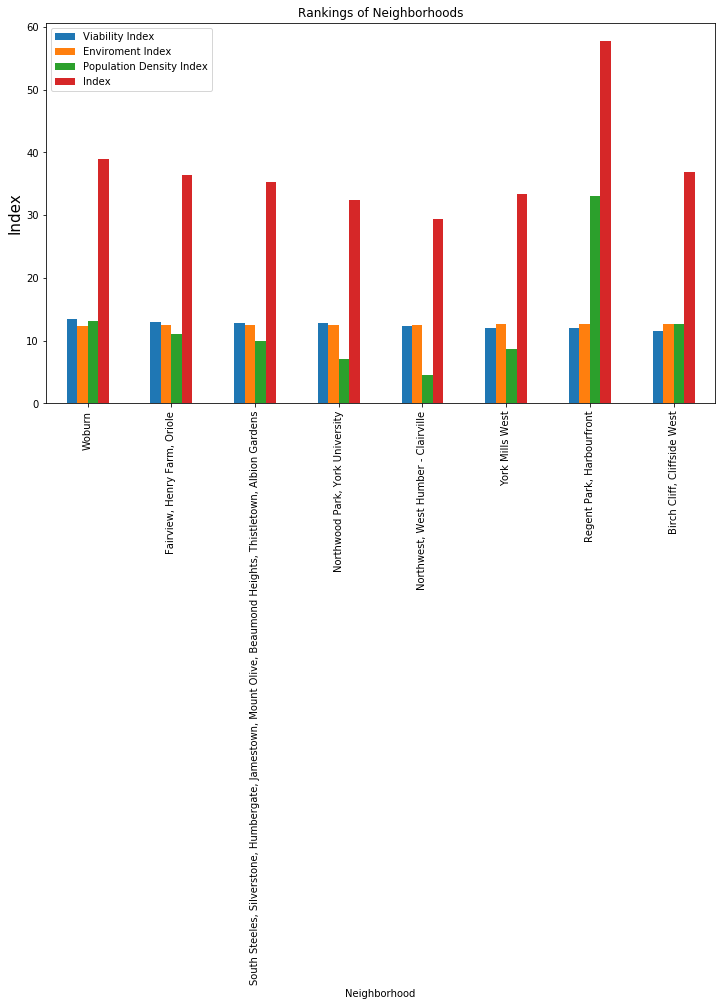

In [626]:
ax = Coffee_Shops.plot(kind='bar', figsize=(12,7))
ax.set_xticklabels(list(Coffee_Shops['Neighbourhood'].values))
plt.title('Rankings of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Index',size=15)
plt.show()

<h3>Section 3</h3>
<h2>Clustering</h2>
A KMeans Clustering algorithm is run to group the neighbourhoods in Toronto into CLusters.

In [628]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

The top 10 Venues in each neighbourhood are computed

In [631]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_Grouped['Neighbourhood']

for ind in np.arange(Toronto_Grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_Grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Coffee Shop,Restaurant,Pharmacy,Bank,Sandwich Place,Indian Restaurant,Pizza Place,Cantonese Restaurant,Bakery
1,"Alderwood, Long Branch",Coffee Shop,Fast Food Restaurant,Pizza Place,Department Store,Café,Seafood Restaurant,Sandwich Place,Restaurant,Clothing Store,Electronics Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Coffee Shop,Park,Pharmacy,Deli / Bodega,Convenience Store,Restaurant,Sandwich Place,Gas Station,Bank
3,Bayview Village,Park,Chinese Restaurant,Coffee Shop,Bank,Clothing Store,Pizza Place,Gas Station,Grocery Store,Restaurant,Pharmacy
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sushi Restaurant,Bakery,Sandwich Place,Pizza Place,Bagel Shop,Pharmacy,Pub,Restaurant


In [632]:
Toronto_Cluster = Toronto_Grouped.drop('Neighbourhood', axis=1)
Toronto_Cluster.head()

,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,0.0,0.0,0.0


In [633]:
# Import the Libraries Required for Clustering
from sklearn.cluster import KMeans

In [634]:
Num_Clusters = 3
kmeans = KMeans(n_clusters=Num_Clusters,random_state=False).fit(Toronto_Cluster)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 2, 0, 2, 1, 2])

In [635]:
Cluster_df = Toronto_Data.drop(['Postal Code','Borough'],axis=1)

In [636]:
Cluster_df = Cluster_df.merge(neighborhoods_venues_sorted,how='right',left_on='Neighbourhood',right_on='Neighborhood')

In [637]:
Cluster_df = Cluster_df.drop_duplicates(subset='Neighbourhood').reset_index(drop=True)

In [638]:
Cluster_df = Cluster_df.drop('Neighborhood',axis=1)

In [639]:
Cluster_df['Cluster Labels'] = kmeans.labels_

In [640]:
Cluster_df.head()

,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Parkwoods,43.753259,-79.329656,Coffee Shop,Japanese Restaurant,Pharmacy,Gas Station,Supermarket,Discount Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Pizza Place,0
1,Victoria Village,43.725882,-79.315572,Coffee Shop,Fast Food Restaurant,Gym,Sandwich Place,Middle Eastern Restaurant,Japanese Restaurant,Clothing Store,Grocery Store,Park,Beer Store,0
2,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Café,Park,Restaurant,Gastropub,Japanese Restaurant,Seafood Restaurant,Diner,Clothing Store,Ice Cream Shop,0
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Coffee Shop,Bank,Furniture / Home Store,Fast Food Restaurant,Dessert Shop,Grocery Store,Vietnamese Restaurant,Italian Restaurant,Restaurant,0
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Restaurant,Pizza Place,Clothing Store,Café,Park,Japanese Restaurant,Comic Shop,Cosmetics Shop,Gastropub,1


A plot of the clusters is generated using Folium

In [641]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(Num_Clusters)
ys = [i + x + (i*x)**2 for i in range(Num_Clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Cluster_df['Latitude'], Cluster_df['Longitude'], Cluster_df['Neighbourhood'], Cluster_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Cluster Results</h2>

0

In [642]:
Zero = Cluster_df.loc[Cluster_df['Cluster Labels'] == 0, Cluster_df.columns[[0] + list(range(3, Cluster_df.shape[1]-1))]]
print(Zero.shape)
Zero.reset_index(drop=True)

(48, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Coffee Shop,Japanese Restaurant,Pharmacy,Gas Station,Supermarket,Discount Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Pizza Place
1,Victoria Village,Coffee Shop,Fast Food Restaurant,Gym,Sandwich Place,Middle Eastern Restaurant,Japanese Restaurant,Clothing Store,Grocery Store,Park,Beer Store
2,"Regent Park, Harbourfront",Coffee Shop,Café,Park,Restaurant,Gastropub,Japanese Restaurant,Seafood Restaurant,Diner,Clothing Store,Ice Cream Shop
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Coffee Shop,Bank,Furniture / Home Store,Fast Food Restaurant,Dessert Shop,Grocery Store,Vietnamese Restaurant,Italian Restaurant,Restaurant
4,"Malvern, Rouge",Zoo Exhibit,Fast Food Restaurant,Zoo,Gas Station,Athletics & Sports,Pizza Place,Paper / Office Supplies Store,Gym,Fried Chicken Joint,African Restaurant
5,"West Deane Park, Princess Gardens, Martin Grov...",Coffee Shop,Convenience Store,Pizza Place,Bank,Grocery Store,Park,Pharmacy,Gym,Fish & Chips Shop,Sushi Restaurant
6,"Rouge Hill, Port Union, Highland Creek",Pizza Place,Breakfast Spot,Coffee Shop,Pharmacy,Pet Store,Bank,Sandwich Place,Neighborhood,Bar,Mexican Restaurant
7,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Coffee Shop,Grocery Store,Bank,Golf Course,Park,Gym,Beer Store,Garden,Gas Station,Sandwich Place
8,"Guildwood, Morningside, West Hill",Pizza Place,Coffee Shop,Bank,Athletics & Sports,Park,Fast Food Restaurant,Breakfast Spot,Bar,Discount Store,Beer Store
9,Woburn,Coffee Shop,Fast Food Restaurant,Sandwich Place,Park,Bank,Discount Store,Supermarket,Indian Restaurant,Chinese Restaurant,Pharmacy


1

In [643]:
One = Cluster_df.loc[Cluster_df['Cluster Labels'] == 1, Cluster_df.columns[[0] + list(range(3, Cluster_df.shape[1]-1))]]
print(One.shape)
One.reset_index(drop=True)

(24, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Queen's Park, Ontario Provincial Government",Coffee Shop,Restaurant,Pizza Place,Clothing Store,Café,Park,Japanese Restaurant,Comic Shop,Cosmetics Shop,Gastropub
1,"Parkview Hill, Woodbine Gardens",Pizza Place,Park,Skating Rink,Sandwich Place,Coffee Shop,Fast Food Restaurant,Beer Store,Ice Cream Shop,Pastry Shop,Mexican Restaurant
2,Glencairn,Clothing Store,Coffee Shop,Furniture / Home Store,Bank,Restaurant,Sushi Restaurant,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,Men's Store
3,Berczy Park,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Plaza,Farmers Market,Park,Italian Restaurant,Beer Bar
4,Caledonia-Fairbanks,Italian Restaurant,Coffee Shop,Sandwich Place,Furniture / Home Store,Bank,Bakery,Mexican Restaurant,Grocery Store,Pizza Place,Mediterranean Restaurant
5,Cedarbrae,Coffee Shop,Clothing Store,Gas Station,Restaurant,Bank,Gym,Sandwich Place,Indian Restaurant,Fast Food Restaurant,Pizza Place
6,"Dufferin, Dovercourt Village",Café,Italian Restaurant,Coffee Shop,Park,Brewery,Bar,Indian Restaurant,Cocktail Bar,Grocery Store,Ethiopian Restaurant
7,"Little Portugal, Trinity",Café,Bakery,Coffee Shop,Pizza Place,Asian Restaurant,Cocktail Bar,Italian Restaurant,Bar,Restaurant,Furniture / Home Store
8,Downsview,Coffee Shop,Vietnamese Restaurant,Pizza Place,Fast Food Restaurant,Gas Station,Clothing Store,Grocery Store,Bank,Sandwich Place,Pharmacy
9,"The Danforth West, Riverdale",Café,Greek Restaurant,Park,Bakery,Coffee Shop,Ice Cream Shop,American Restaurant,Vietnamese Restaurant,Italian Restaurant,Pub


2

In [644]:
Two = Cluster_df.loc[Cluster_df['Cluster Labels'] == 2, Cluster_df.columns[[0] + list(range(3, Cluster_df.shape[1]-1))]]
print(Two.shape)
Two.reset_index(drop=True)

(25, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Islington Avenue, Humber Valley Village",Pharmacy,Coffee Shop,Shopping Mall,Park,Bank,Grocery Store,Liquor Store,Café,Golf Course,Garden
1,Don Mills,Coffee Shop,Restaurant,Japanese Restaurant,Pizza Place,Bank,Sandwich Place,Park,Middle Eastern Restaurant,Italian Restaurant,Supermarket
2,"Garden District, Ryerson",Coffee Shop,Gastropub,Japanese Restaurant,Restaurant,Café,Park,Italian Restaurant,Clothing Store,Thai Restaurant,Bookstore
3,Woodbine Heights,Park,Coffee Shop,Pizza Place,Café,Gastropub,Thai Restaurant,Ice Cream Shop,Skating Rink,Ethiopian Restaurant,Bus Line
4,St. James Town,Coffee Shop,Café,Hotel,Japanese Restaurant,Italian Restaurant,Park,Plaza,Clothing Store,Restaurant,Farmers Market
5,Humewood-Cedarvale,Coffee Shop,Italian Restaurant,Bank,Café,Mexican Restaurant,Trail,Bakery,Indian Restaurant,Park,Caribbean Restaurant
6,The Beaches,Coffee Shop,Pub,Beach,Breakfast Spot,Japanese Restaurant,Bakery,Park,BBQ Joint,Ice Cream Shop,Caribbean Restaurant
7,Hillcrest Village,Coffee Shop,Chinese Restaurant,Bank,Park,Pharmacy,Sandwich Place,Japanese Restaurant,Pizza Place,Bakery,Sushi Restaurant
8,"Richmond, Adelaide, King",Coffee Shop,Café,Hotel,Pizza Place,Park,Japanese Restaurant,Restaurant,Plaza,Clothing Store,Gastropub
9,Scarborough Village,Fast Food Restaurant,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Grocery Store,Department Store,Liquor Store,Gym,Ice Cream Shop


3

In [652]:
latitude = 43.6532
longitude = -79.3832